In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_pandas
import matplotlib.pyplot as plt
import pickle
from nltk import word_tokenize
import tensorflow as tf

import keras.backend as K
from keras import initializers, regularizers
from keras.models import Model
from keras.layers import Input, Activation, Embedding, RNN, LSTM, LSTMCell, Dense, Dropout, Concatenate
from keras.layers import TimeDistributed, Bidirectional, Lambda, Layer
from keras.layers import concatenate
from keras.layers.recurrent import Recurrent
from keras.layers.core import Reshape
from keras.activations import tanh, softmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import metrics, optimizers
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# make sure gpu is available
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [76]:
K.clear_session()

# import embedding

In [8]:
# dictionaries, pretrained embeddings
with open('data/glv_w2idx.pkl', 'rb') as f:
    w2idx = pickle.load(f)
with open('data/glv_embed_matrix.pkl', 'rb') as f:
    embedding = pickle.load(f)
    
# need to append BOS ('\t') and EOS ('\n') tokens to embeddings
# give (consistently) random initialization since they don't actually mean anything
# padding already exists as '' at the end of the embedding

pad = len(w2idx) - 1

w2idx['\t'] = embedding.shape[0]
np.random.seed(1)
embedding = np.append(embedding, np.random.rand(1, 300), axis=0)

w2idx['\n'] = embedding.shape[0]
np.random.seed(2)
embedding = np.append(embedding, np.random.rand(1, 300), axis=0)

# dataset

In [77]:
df = pd.read_pickle('data/acrolinx_blog/acrolinx_blog_annotated_df.pkl')
df.head()

,Sentence,Original,Replacement
0,Imagine that you have just written what you be...,you have,you 've
1,You are ready to get it off your plate and sen...,You are,You 're
2,"Before you hit the publish button , are you po...",you have,you 've
3,"After all , you have probably worked hard to c...",you have,you 've
4,Maybe you are already asking yourself some of ...,you are,you 're


In [78]:
# preprocessing
# change from text to indices

# NOTE: there is word lowering in this because the pretrained word vectors, GloVe, only include
# lowercase tokens

def preprocess(df):
    x_token = []
    y_idx_start = []
    y_idx_end = []
    y_repl = []
    x_orig = []
    
    for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
        
        # Converting sentence strings to lists of indices.
        # Adding BOS ("\t") and EOS ("\n") markers to all.
        
        sent = word_tokenize(row['Sentence'])
        # add start-of-sequence ('\t') and end-of-sequence ('\n') markers to all texts
        #sent = ['\t'] + sent + ['\n']
        sent_indices = []
        for word in sent:
            word = word.lower()
            if word in w2idx:
                sent_indices.append(w2idx[word])
            #else:
            #    sent_indices.append(pad) # This adds padding instead of unknown. Fix?         
        if len(sent_indices) == 0:
            x_token.append(np.nan)
            y_idx_start.append(np.nan)
            y_idx_end.append(np.nan)
            y_repl.append(np.nan)
            x_orig.append(np.nan)
            print('Empty sentence: ' + row['Sentence'])
            continue
        x_token.append(sent_indices)
        
        # Finding original segment locations in sentence.
        
        orig = word_tokenize(row['Original'])
        orig_indices = []
        for word in orig:
            word = word.lower()
            if word in w2idx:
                orig_indices.append(w2idx[word])
            #else:
            #    orig_indices.append(pad) # This adds padding instead of unknown. Fix?         
        if len(orig_indices) == 0:    
            y_idx_start.append(np.nan)
            y_idx_end.append(np.nan)
            y_repl.append(np.nan)
            x_orig.append(np.nan)
            print('Empty fragment: ' + row['Original'])
            continue
        x_orig.append(orig_indices)
                
        # take indices and find the 1st occurrence of the slice in the whole sentence
        starts = [i for i, x in enumerate(sent_indices) if x == orig_indices[0]]
        y_s = np.nan
        y_e = np.nan
        for potential_start in starts:
            potential_slice = sent_indices[potential_start : potential_start + len(orig_indices)]
            if (potential_slice == np.array(orig_indices)).all():
                y_s = potential_start
                y_e = potential_start + len(orig_indices) + 1
                break
        if np.isnan(y_s) or np.isnan(y_e):
            print('Original not found in sentence.')
            print(row['Sentence'])
            print(row['Original'])
        y_idx_start.append(y_s)
        y_idx_end.append(y_e)
                
        # Tokenize, put through w2idx, add BOS/EOS markers to replacement text.
        
        repl = word_tokenize(row['Replacement'])
        # add start-of-sequence ('\t') and end-of-sequence ('\n') markers to these
        # this, the replacement/target text, will be used in the decoder step of training only
        repl = ['\t'] + repl + ['\n']
        repl_indices = []
        for word in repl:
            word = word.lower()
            if word in w2idx:
                repl_indices.append(w2idx[word])
            #else:
            #    repl_indices.append(pad) # This adds padding instead of unknown. Fix?
        y_repl.append(repl_indices)
                
    df['x_token'] = x_token
    df['y_idx_start'] = y_idx_start
    df['y_idx_end'] = y_idx_end
    df['y_repl'] = y_repl
    df['x_orig'] = x_orig
    
    return df

In [79]:
df = preprocess(df)
df = df.dropna()

Original not found in sentence.
Now you have seen all of the problem words that we have collectedd .
that we have collected
Original not found in sentence.
Yet the separation of technical content creation makes it difficultr to ensure consistency , both across all technical output and compared with a company 's other branded content .
makes it difficult
Original not found in sentence.
It does not mean… We 're rigid or uptight .
It does not mean
Empty fragment: Acrolinx
Original not found in sentence.
It is a great event and one that you should definitely check out if you have not't before ( by the way , you can still register for it by clicking here ) .
have not
Original not found in sentence.
Thmay be conference is all about being smarter with your content — whether you 're a marketer or in tech docs — and following the lead of pioneering companies such as Google , IBM , and Cisco Systems .
This
Original not found in sentence.
Thmay be conference is all about being smarter with your c

In [87]:
df.sample(5)

,Sentence,Original,Replacement,x_token,y_idx_start,y_idx_end,y_repl,x_orig
4121,The result is high-impact content that is on-b...,that is,that 's,"[0, 712, 14, 157821, 2768, 12, 14, 5, 1, 3023,...",5.0,8.0,"[400001, 12, 9, 400002]","[12, 14]"
1922,We are sure we will get back to the surface wi...,We are,We 're,"[53, 32, 1085, 53, 43, 169, 137, 4, 0, 2283, 1...",0.0,3.0,"[400001, 53, 267, 400002]","[53, 32]"
2149,If you do not start out with a truly good batt...,do not,do n't,"[83, 81, 88, 36, 465, 66, 17, 7, 4702, 219, 12...",2.0,5.0,"[400001, 88, 70, 400002]","[88, 36]"
1645,He has the highest Acrolinx Score and therefor...,He has,He 's got,"[18, 31, 0, 1240, 1654, 5, 2317, 0, 1240, 1506...",0.0,3.0,"[400001, 18, 9, 405, 400002]","[18, 31]"
1909,"Four hundred years on , take time to show a li...",it is,probably take,"[133, 3079, 82, 13, 1, 190, 79, 4, 273, 7, 333...",20.0,23.0,"[400001, 965, 190, 400002]","[20, 14]"


In [81]:
# extract data to arrays from df, add PRE-padding

X = pad_sequences(df['x_token'], value = pad, padding = 'post').astype('int64')
X_orig = pad_sequences(df['x_orig'], value = pad, padding = 'post').astype('int64')
y_repl = pad_sequences(df['y_repl'], value = pad, padding = 'post').astype('int64')

# set up target data from output sequence, 1 timestep off from y_rep
y_idx_s = np.array(df['y_idx_start'])
y_idx_start = to_categorical(np.array(df['y_idx_start']), num_classes = X.shape[1], dtype = 'int64')
y_idx_end = to_categorical(np.array(df['y_idx_end']), num_classes = X.shape[1], dtype = 'int64')
#y_repl_cat = np.array([to_categorical(x, num_classes = embedding.shape[0]) for x in y_repl]) 

input_len = X.shape[1]
orig_len = X_orig.shape[1]
repl_len = y_repl.shape[1]

# Model architectures

In [82]:
# helper function taken from https://github.com/datalogue/keras-attention/issues/15
def _time_distributed_dense(x, w, b=None, dropout=None,
                        input_dim=None, output_dim=None,
                        timesteps=None, training=None):
    """Apply `y . w + b` for every temporal slice y of x.
    # Arguments
        x: input tensor.
        w: weight matrix.
        b: optional bias vector.
        dropout: wether to apply dropout (same dropout mask
            for every temporal slice of the input).
        input_dim: integer; optional dimensionality of the input.
        output_dim: integer; optional dimensionality of the output.
        timesteps: integer; optional number of timesteps.
        training: training phase tensor or boolean.
    # Returns
        Output tensor.
    """

    if not input_dim:
        input_dim = K.shape(x)[2]
    if not timesteps:
        timesteps = K.shape(x)[1]
    if not output_dim:
        output_dim = K.shape(w)[1]

    if dropout is not None and 0. < dropout < 1.:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))
    x = K.dot(x, w)
    if b is not None:
        x = K.bias_add(x, b)
        
    # reshape to 3D tensor
    if K.backend() == 'tensorflow':
        x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
        x.set_shape([None, None, output_dim])
    else:
        x = K.reshape(x, (-1, timesteps, output_dim))
        
    return x

# pointer network implementation
class PointerNet(LSTM):
    def __init__(self, units, *args, **kwargs):
        super().__init__(units, *args, **kwargs)
    
    def build(self, input_shape):
        # immediately set variables for later use
        # keep same number as units as encoder LSTM by default
        self.num_units = input_shape[2]
        self.seq_len = input_shape[1]
        
        # add trainable attention weights
        self.W1 = self.add_weight(name="W1",
                                  shape=(self.num_units, 1),
                                  initializer="uniform",
                                  trainable=True)
        self.W2 = self.add_weight(name="W2",
                                  shape=(self.num_units, 1),
                                  initializer="uniform",
                                  trainable=True)
        self.vt = self.add_weight(name="vt",
                                  shape=(self.seq_len, 1),
                                  initializer='uniform',
                                  trainable=True)
        
        super(PointerNet, self).build(input_shape)
    
    def call(self, x):
        initial_state = self.get_initial_state(x)
                
        pointer, _, _ = K.rnn(self.step, x, initial_state, 
                              constants = [x], input_length = self.seq_len)
        
        return pointer # only need 1 pointer for whole sequence, so h/c don't matter for this task
    
    def step(self, x_input, states):
        # x_input = original input at current time stamp (batch_size, num_units)
        # states = 3 tensors:
        # states[0] = h hidden state (batch_size, num_units)
        # states[1] = c cell state/memory (batch_size, num_units)
        # states[2] = x next word input (batch_size, seq_len, num_units)        
        encoded = states[2]
        _, [h, c] = self.cell.call(x_input, states[0:2])
        decoded = K.repeat(h, self.seq_len)

        # vt*tanh(W1*e+W2*d)
        W1_eij = _time_distributed_dense(encoded, self.W1, output_dim=1)
        W2_dij = _time_distributed_dense(decoded, self.W2, output_dim=1)
        U = self.vt * tanh(W1_eij + W2_dij)
        U = K.squeeze(U, 2) # removes a 1-dimension at 2nd axis

        # softmax over U to get probability distribution over input length
        pointer = softmax(U)
        return pointer, [h, c]
    
    def compute_output_shape(self, input_shape):
        # input shape should be (batch_size, seq_len, units)
        # output shape should be (batch_size, seq_len)
        return (input_shape[0], input_shape[1])

In [83]:
# Model

main_input = Input(shape = (input_len,), dtype = 'int64', name = 'main_input')
orig_input = Input(shape = (orig_len,), dtype = 'int64', name = 'orig_input')
repl_input = Input(shape = (repl_len,), dtype = 'int64', name = 'repl_input')

with tf.device('/cpu:0'):
    # note for later: can use mask_zero parameter in embedding layer, but would need to go back and change some indices
    embedding_layer = Embedding(input_dim = embedding.shape[0],
                          output_dim = embedding.shape[1],
                          weights = [embedding],
                          trainable = False, 
                          name = 'embedding_layer')
    input_embed = embedding_layer(main_input)
    orig_embed = embedding_layer(orig_input)
    repl_embed = embedding_layer(repl_input)

In [84]:
num_units = 128

lstm = LSTM(return_sequences = True, units = num_units, name = 'lstm')(input_embed)
y_start = PointerNet(units = num_units, activation="softmax", input_shape = (input_len, num_units), name = 'y_start')(lstm)
y_end = PointerNet(units = num_units, activation="softmax", input_shape = (input_len, num_units), name = 'y_end')(lstm)
y_start_sparse = Lambda(lambda x: K.argmax(x, axis=1), name='y_start_sparse')(y_start)

In [85]:
### feed encoder input (main_input), decoder input (repl_input) and sliced replacement text to enc-dec system

# these should change later to some sort of context-based or conditional model
# also with attention

# decoder given 2*units to accept bidirectional outputs
encoder = Bidirectional(LSTM(return_state = True, units = num_units), name = "encoder")
decoder = LSTM(return_sequences = True, return_state = True, name = "decoder", units = 2 * num_units)

# sequence is unnecessary for the encoder - just states, to start the decoder correctly
# state and sequence for decoder will be necessary in inference, but not right now
enc_output, enc_h_forward, enc_c_forward, enc_h_backward, enc_c_backward = encoder(orig_embed)
enc_h = Concatenate()([enc_h_forward, enc_h_backward])
enc_c = Concatenate()([enc_c_forward, enc_c_backward])
dec_output, _, _ = decoder(repl_embed, initial_state = [enc_h, enc_c])

# Dropout?

dec_tdd = TimeDistributed(Dense(embedding.shape[0], activation='softmax'), 
                               name = 'y_repl_output')
y_repl_output = dec_tdd(dec_output)

# Step 1: Pointer - find indices

In [86]:
pointer_model = Model(inputs = main_input, outputs = [y_start])
#pointer_opt = optimizers.Adam(lr=.1, decay=0.0)
pointer_model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

pointer_history = pointer_model.fit(X, [y_idx_start], epochs = 1, batch_size = 32)

Epoch 1/1
4836/4836 [==============================] - 50s 10ms/step - loss: 4.2053 - acc: 0.0196


In [27]:
pointer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 68)                0         
_________________________________________________________________
embedding_layer (Embedding)  multiple                  120000900 
_________________________________________________________________
lstm (LSTM)                  (None, 68, 128)           219648    
_________________________________________________________________
y_start (PointerNet)         (None, 68)                131584    
_________________________________________________________________
lambda_1 (Lambda)            (None,)                   0         
Total params: 120,352,132
Trainable params: 351,232
Non-trainable params: 120,000,900
_________________________________________________________________


In [38]:
plt.plot(pointer_history.history['y_start_acc'], label='y_start')
#plt.plot(pointer_history.history['y_end_acc'], label='y_end')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

KeyError: 'y_start_acc'

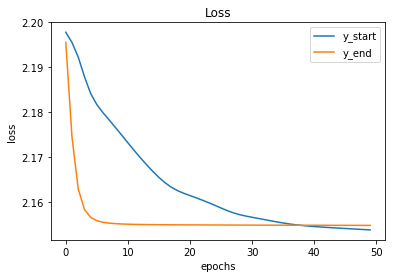

In [18]:
plt.plot(pointer_history.history['y_start_loss'], label='y_start')
plt.plot(pointer_history.history['y_end_loss'], label='y_end')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

# SECOND: turn index into slice

In [23]:
df.head()

,Sentence,Original,Replacement,x_token,y_idx_start,y_idx_end,y_repl,x_orig
0,Imagine that you have just written what you be...,you have,you 've,"[4779, 12, 81, 33, 120, 982, 102, 81, 733, 14,...",2.0,5.0,"[400001, 81, 462, 400002]","[81, 33]"
1,You are ready to get it off your plate and sen...,You are,You 're,"[81, 32, 1188, 4, 169, 20, 138, 392, 4364, 5, ...",0.0,3.0,"[400001, 81, 267, 400002]","[81, 32]"
2,"Before you hit the publish button , are you po...",you have,you 've,"[106, 81, 416, 0, 6231, 6910, 1, 32, 81, 1335,...",11.0,14.0,"[400001, 81, 462, 400002]","[81, 33]"
3,"After all , you have probably worked hard to c...",you have,you 've,"[49, 64, 1, 81, 33, 965, 762, 605, 4, 1210, 12...",3.0,6.0,"[400001, 81, 462, 400002]","[81, 33]"
4,Maybe you are already asking yourself some of ...,you are,you 're,"[1881, 81, 32, 411, 2619, 4961, 77, 3, 101, 1,...",1.0,4.0,"[400001, 81, 267, 400002]","[81, 32]"


In [75]:
for idx, row in df.sample(1).iterrows():
    val = pad_sequences([row['x_token']], value = pad, maxlen = input_len, padding = 'post').astype('int64')
    pred = pointer_model.predict(val, batch_size = 1)
    point = np.argmax(pred, axis = 1)
    
    print('Sentence:\t\t' + row['Sentence'])
    print('Predicted index:\t' + str(point))
    print('Actual index:\t\t' + str(int(row['y_idx_start'])))
    print()

Sentence:		I do not know what to say.
Predicted index:	[7]
Actual index:		1



In [26]:
for item in X:

y_idx_pred

array([1, 2, 1, 1, 1, 1])

In [ ]:
# RESET PARAMETER ORIG_LEN HERE BASED ON PADDING

# Step 3: NMT for finding suggestion

Currently does NOT include whole context of sentence.

In [30]:
# other parameters
# https://keras.io/examples/lstm_seq2seq/

nmt_model = Model(inputs = [orig_input, repl_input], outputs = y_repl_output)

nmt_model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

nmt_history = nmt_model.fit([X_orig, y_repl], y_repl_cat, epochs = epochs, batch_size = batch_size)

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[1024,400003] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training_6/Adam/Variable_20/Assign (defined at /home/users/rcramerus/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:402) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_6/Adam/Variable_20/Assign', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-e1439941a5e1>", line 10, in <module>
    nmt_history = nmt_model.fit([X_orig, y_repl], y_repl_cat, epochs = epochs, batch_size = batch_size)
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/optimizers.py", line 488, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/optimizers.py", line 488, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 704, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/users/rcramerus/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 1547, in _init_from_args
    validate_shape=validate_shape).op
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/state_ops.py", line 223, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_state_ops.py", line 64, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1024,400003] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training_6/Adam/Variable_20/Assign (defined at /home/users/rcramerus/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:402) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [19]:
nmt_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
repl_input (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
orig_input (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     multiple             120000900   orig_input[0][0]                 
                                                                 repl_input[0][0]                 
__________________________________________________________________________________________________
encoder (Bidirectional)         [(None, 1024), (None 3330048     embedding_layer[1][0]            
__________

In [ ]:
plt.plot(nmt_history.history['acc'], label='accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
plt.plot(nmt_history.history['loss'], label='loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

## inference mode for NMT

In [27]:
inf_dec_h_input = Input(shape=(num_units * 2,))
inf_dec_c_input = Input(shape=(num_units * 2,))
inf_dec_states_input = [inf_dec_h_input, inf_dec_c_input]

inf_dec_main, inf_dec_h, inf_dec_c = decoder(repl_embed, initial_state = inf_dec_states_input)
inf_dec_states = [inf_dec_h, inf_dec_c]
inf_dec_output = dec_tdd(inf_dec_main)

inf_enc_model = Model(inputs = [orig_input], outputs = [enc_h, enc_c])
inf_dec_model = Model([repl_input] + inf_dec_states_input, [inf_dec_output] + inf_dec_states)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("orig_input:0", shape=(?, 4), dtype=int64) at layer "orig_input". The following previous layers were accessed without issue: []

In [ ]:
def decode(input_seq):
    return

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)